# Charp 03 Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Linear Regression](#3.3-Other-Linear-Regression)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf



%matplotlib inline


C:\Users\wei\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
plt.style.use('fivethirtyeight')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [3]:
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [4]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Income       400 non-null float64
Limit        400 non-null int64
Rating       400 non-null int64
Cards        400 non-null int64
Age          400 non-null int64
Education    400 non-null int64
Gender       400 non-null object
Student      400 non-null object
Married      400 non-null object
Ethnicity    400 non-null object
Balance      400 non-null int64
Student2     400 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB


In [8]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

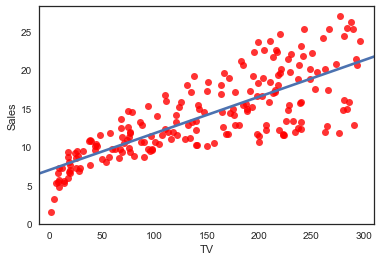

In [14]:
sns.regplot(advertising.TV, advertising.Sales, ci=None, scatter_kws={'color':'r'}, order=1)
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS

In [15]:
regr = skl_lm.LinearRegression()
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1, 1)
y = advertising.Sales
regr.fit(X, y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[ 0.04753664]


In [20]:
# create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx,yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size, B1.size))

# calculate Z-values(rss) based on grid of coordinates
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = ((y - (xx[i,j] + X.ravel()*yy[i,j]))**2).sum()/1000

# minimum RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+ regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

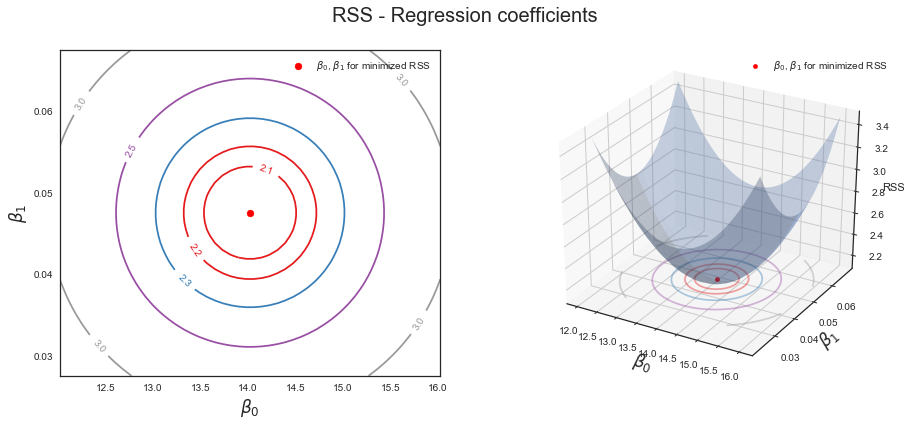

In [28]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx,yy,Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
           alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(), Z.max())
ax2.set_ylim(0.02, 0.07)

# Setting common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03, 0.04, 0.05, 0.06])
    ax.legend()


### Confidence interval

In [29]:
est = smf.ols('Sales ~ TV', advertising).fit()

In [30]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sat, 06 Jan 2018   Prob (F-statistic):           1.47e-42
Time:                        12:23:30   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [33]:
est.params

Intercept    7.032594
TV           0.047537
dtype: float64

In [34]:
# RSS with regression coefficients
((advertising.Sales- (est.params[0]+ est.params[1]*advertising.TV))**2).sum()/1000

2.102530583131352

In [38]:
regr.residues_

C:\Users\wei\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


2102.5305831313517

In [39]:
# 不对数据进行标准化来训练
X = advertising.TV.values.reshape(-1, 1)
y = advertising.Sales
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
regr.intercept_

7.032593549127693

In [41]:
regr.coef_

array([ 0.04753664])

In [42]:
regr.residues_

C:\Users\wei\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


2102.5305831313517

In [43]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.61187505085007099

## 3.2 Multiple Linear Regression

### Table 3.3 - Statsmodels

In [44]:
est = smf.ols('Sales~Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [45]:
est = smf.ols('Sales~Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


In [46]:
est = smf.ols('Sales~ TV + Radio + Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


In [50]:
advertising.iloc[:,:-1].corr()

,TV,Radio,Newspaper
TV,1.000000,0.054809,0.056648
Radio,0.054809,1.000000,0.354104
Newspaper,0.056648,0.354104,1.000000


In [51]:
# Sklearn method
regr = skl_lm.LinearRegression()

In [52]:
X = advertising[['Radio', 'TV']].as_matrix()
y = advertising.Sales
regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

2.92109991241
[ 0.18799423  0.04575482]


In [55]:
# Create a coordinate grid
Radio = np.arange(0, 50)
TV = np.arange(0, 300)
B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = (regr.intercept_+regr.coef_[0]*B1[i,j] + regr.coef_[1]*B2[i,j])

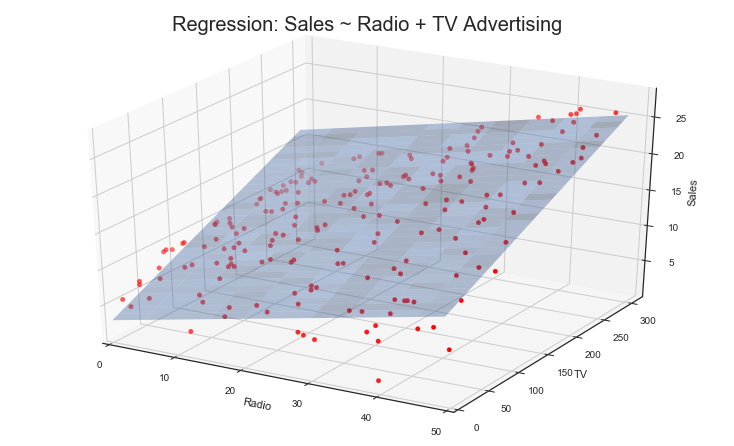

In [57]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle("Regression: Sales ~ Radio + TV Advertising", fontsize=20)

ax = axes3d.Axes3D(fig)
ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0, 50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

## 3.3 Other Linear Regression

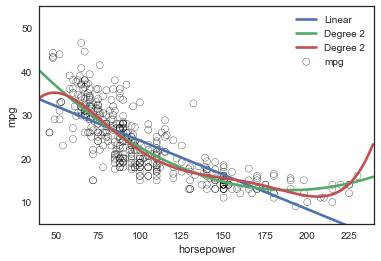

In [67]:
 # with seaborn's regplot() you can easily plot higher order polynomial.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k')
sns.regplot('horsepower', 'mpg', data=auto, ci=None, label='Linear', scatter=False)
sns.regplot('horsepower', 'mpg', data=auto, ci=None, label='Degree 2',order=2, scatter=False)
sns.regplot('horsepower', 'mpg', data=auto, ci=None, label='Degree 2',order=5, scatter=False)
plt.legend()
plt.xlim(40,240)
plt.ylim(5,55);

In [68]:
# use smf.ols to fit
auto['horsepower2'] = auto.horsepower**2
est = smf.ols('mpg~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [70]:
# use sklearn method
regr = skl_lm.LinearRegression()

In [71]:
# linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)
auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto['pred1']

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)
auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto['pred2']

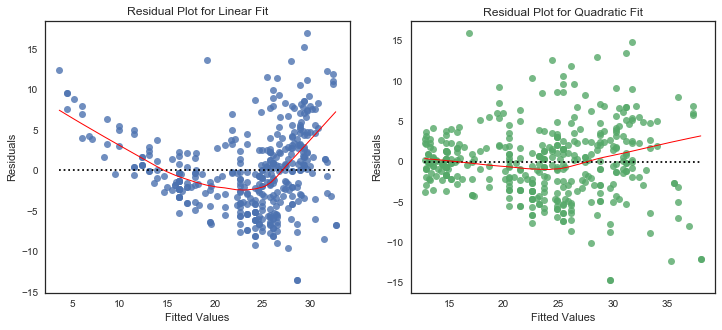

In [76]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True,
           ax=ax1, line_kws={'color':'r', 'lw':1})
ax1.hlines(0, xmin=ax1.xaxis.get_data_interval()[0],
          xmax=ax1.xaxis.get_data_interval()[1], linestyle='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
           ax=ax2, line_kws={'color':'r', 'lw':1})
ax2.hlines(0, xmin=ax2.xaxis.get_data_interval()[0],
          xmax=ax2.xaxis.get_data_interval()[1], linestyle='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel("Residuals")

In [77]:
est.rsquared

0.68755903051275147

In [78]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Sat, 06 Jan 2018   Prob (F-statistic):           5.40e-99
Time:                        14:55:00   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      56.9001      1.800     31.604      0.000      53.360      60.440
horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
from sklearn.datasets.samples_generator import make_blobs

In [5]:
(X, y) = make_blobs(n_samples=300, n_features=2, centers=2,
                    cluster_std=1.1, random_state=42)

In [6]:
X = np.c_[np.ones((X.shape[0])), X]

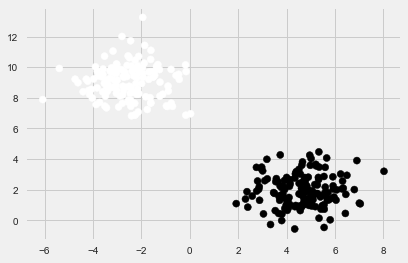

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 1], X[:, 2], marker='o', c=y)
plt.ion()
plt.show()


In [14]:
W = np.random.uniform(size=(X.shape[1],))


In [15]:
Y = (-W[0] - (W[1]*X)) / W[2]

In [41]:
lines = ax.plot(X, Y, 'r--')


In [19]:
plt.show()

In [32]:
%matplotlib inline
lines =ax.plot(X, Y, 'r--')
plt.show()

In [36]:
ax = fig.add_subplot(1, 1, 1)
ax.plot(X, Y, 'r--');

In [42]:
lines

In [43]:
ax.lines.remove(lines[0])

In [44]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', '_sh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'plt', 'axes3d', 'sns', 'scale', 'skl_lm', 'mean_squared_error', 'r2_score', 'sm', 'smf', '_i2', '_i3', '_i4', 'make_blobs', '_i5', 'X', 'y', '_i6', '_i7', 'fig', 'ax', '_i8', '_i9', '_i10', '_i11', '_i12', '_i13', '_i14', 'W', '_i15', 'Y', '_i16', 'lines', '_i17', '_i18', '_18', '_i19', '_i20', '_i21', '_i22', '_22', '_i23', '_i24', '_i25', '_25', '_i26', '_i27', '_27', '_i28', '_i29', '_29', '_i30', '_i31', '_i32', '_i33', '_33', '_i34', '_34', '_i35', '_i36', '_i37', '_37', '_i38', '_38', '_i39', '_i40', '_i41', '_i42', '_42', '_i43', '_i44'])